In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path
import re
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Read and Explore the Data

In [3]:
path = Path('../input/covid-19-nlp-text-classification/')

train_df = pd.read_csv(path / 'Corona_NLP_train.csv', encoding = 'latin1')
test_df = pd.read_csv(path / 'Corona_NLP_test.csv', encoding = 'latin1')

df = pd.concat([train_df, test_df], ignore_index=True)

In [4]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
44950,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
44951,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
44952,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
44953,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [5]:
df['Sentiment']. value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

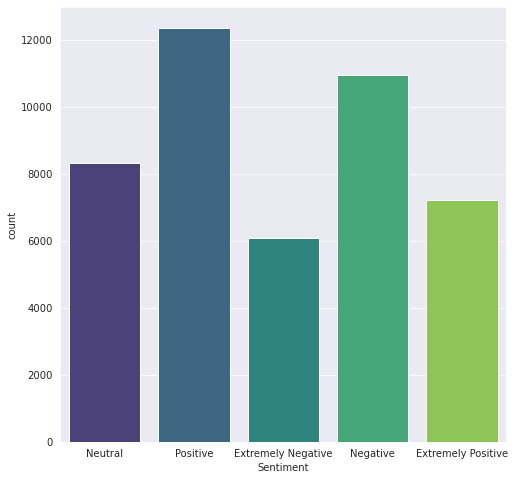

In [6]:
#class distributions
sns.set_style('darkgrid')
plt.figure(figsize = (8, 8))
sns.countplot(x = df['Sentiment'] , palette = 'viridis')
plt.show()

In [7]:
#drop unrelated columns
df = df.drop(columns = ['UserName', 'ScreenName', 'Location', 'TweetAt'])
df.reset_index(drop=True, inplace=True)
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
df= df[df['Sentiment'] != "Neutral"]

In [9]:
df['Sentiment']. value_counts()

Positive              12369
Negative              10958
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

In [10]:
label_map= {'Positive':1, "Extremely Positive":1,'Negative':0, "Extremely Negative":0 }
df['label'] = df['Sentiment'].map(label_map)
df['label'].value_counts()

1    19592
0    17031
Name: label, dtype: int64

# TEXT CLENAING

In [11]:
# Remove link,user and special characters
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def clean_text(text):
    return  re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()

In [12]:
df['OriginalTweet'][3]

"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j"

In [13]:
clean_text(df['OriginalTweet'][3])


'my food stock is not the only one which is empty please don t panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid 19 covid19 coronavirus confinement confinementotal confinementgeneral'

In [14]:
df['OriginalTweet'].apply(lambda x: clean_text(x))


1        advice talk to your neighbours family to excha...
2        coronavirus australia woolworths to give elder...
3        my food stock is not the only one which is emp...
4        me ready to go at supermarket during the covid...
5        as news of the region s first confirmed covid ...
                               ...                        
44949    mdcounties craig will you call on the general ...
44950    meanwhile in a supermarket in israel people da...
44951    did you panic buy a lot of non perishable item...
44953    gov need to do somethings instead of biar je r...
44954    i and forestandpaper members are committed to ...
Name: OriginalTweet, Length: 36623, dtype: object

# Tokenize

In [15]:
#Gensim’s simple_preprocess allows you to convert text to lower case and remove punctuations and tokenize text

def apply_simple_process_to_tokenize(df):
    df['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in df['OriginalTweet']]
    return df

In [16]:
df = apply_simple_process_to_tokenize(df)

In [17]:
print(df['OriginalTweet'][1])
print()
print(df['tokenized_text'][1])
print()
print(df['label'][1])

advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order

['advice', 'talk', 'to', 'your', 'neighbours', 'family', 'to', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'with', 'phone', 'numbers', 'of', 'neighbours', 'schools', 'employer', 'chemist', 'gp', 'set', 'up', 'online', 'shopping', 'accounts', 'if', 'poss', 'adequate', 'supplies', 'of', 'regular', 'meds', 'but', 'not', 'over', 'order']

1


# Apply Stemming

In [18]:
#reduce the words into root word-> Porter Stammer, Lancaster Stammer, SnowballStemmer
def apply_stemming(df):
    porter_stemmer = PorterStemmer()
    # Get the stemmed_tokens
    df['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in df['tokenized_text']]
    return df

In [19]:
df = apply_stemming(df)

In [20]:
print(df['OriginalTweet'][1])
print()
print(df['tokenized_text'][1])
print()
print(df['stemmed_tokens'][1])
print()
print(df['label'][1])

advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order

['advice', 'talk', 'to', 'your', 'neighbours', 'family', 'to', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'with', 'phone', 'numbers', 'of', 'neighbours', 'schools', 'employer', 'chemist', 'gp', 'set', 'up', 'online', 'shopping', 'accounts', 'if', 'poss', 'adequate', 'supplies', 'of', 'regular', 'meds', 'but', 'not', 'over', 'order']

['advic', 'talk', 'to', 'your', 'neighbour', 'famili', 'to', 'exchang', 'phone', 'number', 'creat', 'contact', 'list', 'with', 'phone', 'number', 'of', 'neighbour', 'school', 'employ', 'chemist', 'gp', 'set', 'up', 'onlin', 'shop', 'account', 'if', 'poss', 'adequ', 'suppli', 'of', 'regular', 'med', 'but', 'not', 'over', 'order']

1


# Word Vectors

In [21]:
size = 200
window = 3
workers = 3
sg = 1

# Function to train word2vec or FastText model
def make_word_vector_model(df, padding=True, sg=1, size=100, workers=3, window=3, word2vec = True):
    
    if  padding: #include the 'pad' word to get a word vector for padding
        print(len(df))
        temp_df = pd.Series(df['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
       
    else:
        temp_df = df['stemmed_tokens']
        
        
    if word2vec:
        return Word2Vec(temp_df,  size = size, min_count=5, workers = workers, window = window, sg = sg)
    else:
        return FastText(temp_df,  size = size, min_count=5, workers = workers, window = window, sg = sg)     

In [22]:
# Train Word2vec model
w2vmodel = make_word_vector_model(df, padding=True, sg=sg, size=size, workers=workers, window=window, word2vec = True)

36623


In [23]:
w2vmodel.wv.most_similar("man")

[('woman', 0.8541833758354187),
 ('ladi', 0.8278080224990845),
 ('allegedli', 0.7635944485664368),
 ('twist', 0.7497348189353943),
 ('mother', 0.737544059753418),
 ('intention', 0.7297983169555664),
 ('camera', 0.7293235659599304),
 ('purposefulli', 0.7268612384796143),
 ('assault', 0.719545841217041),
 ('purpos', 0.7167271375656128)]

In [24]:
# Train FastText model
fastText_model = make_word_vector_model(df, padding=True, sg=sg, size=size, workers=workers, window=window, word2vec = False)

36623


In [25]:
fastText_model.wv.most_similar("man")

[('woman', 0.8470180034637451),
 ('oman', 0.8307955265045166),
 ('batman', 0.7707554697990417),
 ('wegman', 0.7660701274871826),
 ('nan', 0.7419171333312988),
 ('pacman', 0.7348257303237915),
 ('salman', 0.7319042086601257),
 ('huntsman', 0.7302365899085999),
 ('ladi', 0.7280776500701904),
 ('allegedli', 0.7233734130859375)]

In [26]:
max_sen_len = df['stemmed_tokens'].map(len).max()
max_sen_len_idx = df['stemmed_tokens'].map(len).argmax()
print("Tweet with a maximum word count- id:", max_sen_len_idx, " and the word count:",max_sen_len)

Tweet with a maximum word count- id: 16310  and the word count: 60


In [27]:
#function to get word_vector representations of a stemmed sentence, will be used for every tweet before feeding them to cnn
def make_word_vector_for_cnn(sentence, max_sen_len, padding_idx, word2vec = True):
    padded_X = [padding_idx for i in range(max_sen_len)]
    
    word_vector_model = w2vmodel if word2vec else fastText_model
    
    i = 0
    for word in sentence:
        if word not in word_vector_model.wv.vocab:
            padded_X[i] = 0
        else:
            padded_X[i] = word_vector_model.wv.vocab[word].index
        i += 1
        
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

In [28]:
# Function to get the output as a tensor
def make_target(label):
    if label == 0:
        return torch.tensor([0], dtype=torch.long, device=device)
    else:
        return torch.tensor([1], dtype=torch.long, device=device)

In [29]:
# Train Test Split Function
def split_train_test(df, test_size=0.2, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df[['stemmed_tokens']], 
                                                        df['label'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=1)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print()
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print()
    
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

In [30]:
# Call the train_test_split
x_train, x_test, y_train, y_test = split_train_test(df)

Value counts for Train sentiments
1    15668
0    13630
Name: label, dtype: int64

Value counts for Test sentiments
1    3924
0    3401
Name: label, dtype: int64

   index                                     stemmed_tokens
0  41546  [how, ar, you, encourag, your, client, and, co...
1  43407  [panic, in, citi, amid, partial, lockdown, gov...
2   3099  [scammer, ar, take, advantag, of, fear, surrou...
3  34380  [to, all, the, healthcar, worker, law, enforc,...
4    196  [gt, massgovernor, announc, loan, fund, admini...


In [31]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)


Device available for running: 
cuda


#how to create a conv layer list with list comprehension

EMBEDDING_SIZE = 200
NUM_FILTERS = 10

window_sizes=(1,2,3,5)

conv_layer_list = nn.ModuleList([ nn.Conv2d(1, NUM_FILTERS, 
                            [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0)) for window_size in window_sizes])

conv_layer_list

In [75]:
#model codes
import numpy as np

EMBEDDING_SIZE = 200
RNN_SIZE=100
import gensim

class CnnTextClassifier(nn.Module):
    
    def __init__(self, vocab_size, num_classes, word_vector_model=w2vmodel):
        super(CnnTextClassifier, self).__init__()
        
        self.n_layers = 1
        self.hidden_dim = 100
    
        weights = word_vector_model.wv
        
        #define the layers
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors),
                                                      padding_idx=word_vector_model.wv.vocab['pad'].index)

        
        #lstm layer
        self.lstm = nn.LSTM(EMBEDDING_SIZE, self.hidden_dim,self.n_layers, batch_first=True)     
        

        self.fc = nn.Linear(self.hidden_dim * 60, num_classes)
        

    def forward(self, x):
        #create the model
        # embeddings and lstm_out
        batch_size = x.size(0)
        x = self.embedding(x)
        #print(x.shape)
        lstm_out, hidden = self.lstm(x)
        #lstm_out=lstm_out[ : , -1, : ] 
        #print(lstm_out.shape)
        #flatten_dim = np.prod(lstm_out.shape)
        #lstm_out=lstm_out.view(-1, flatten_dim)
        #print(lstm_out.shape)
        lstm_out = lstm_out.view(-1, np.prod(lstm_out.shape))
        
        out = self.fc(lstm_out)
        probs = F.softmax(out, dim = 1)
        
        return probs
    
    

# Train the network with Word2Vec pretrained vectors

In [ ]:
#function to output the performance of the trained model
def print_classification_report(wor2vec=True):
    cnn_predictions = []
    original_lables = []
    cnn_model.eval()
    
    with torch.no_grad():
        for index, row in x_test.iterrows():
            bow_vec= make_word_vector_for_cnn(row['stemmed_tokens'],
                                           max_sen_len=max_sen_len,
                                           padding_idx=padding_idx ,
                                           word2vec = True)
            
            probs = cnn_model(bow_vec)
            
            #get the predicted class
            _, predicted = torch.max(probs.data, 1)
            
            #append to the lists to later see the performance
            cnn_predictions.append(predicted.cpu().numpy()[0])
            original_lables.append(make_target(y_test['label'][index]).cpu().numpy()[0])
    
    print(classification_report(original_lables, cnn_predictions))       


In [ ]:
#funtion where the training is executed

def train_the_model(VOCAB_SIZE, padding_idx, cnn_model, word2vec=True ):
    cnn_model.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
    num_epochs = 30


    losses = []
    cnn_model.train()
    for epoch in range(num_epochs):
        print("Epoch" + str(epoch + 1))
        train_loss = 0
        for index, row in x_train.iterrows():
            # Clearing the accumulated gradients
            cnn_model.zero_grad()

            # Make the bag of words vector for stemmed tokens 
            bow_vec = make_word_vector_for_cnn(row['stemmed_tokens'],
                                           max_sen_len=max_sen_len,
                                           padding_idx=padding_idx ,
                                           word2vec = word2vec)
       
            # Forward pass to get output
            probs = cnn_model(bow_vec)

            # Get the target label
            target = make_target(y_train['label'][index])

            # Calculate Loss: softmax --> cross entropy loss
            loss = loss_function(probs, target)
            train_loss += loss.item()

            # Getting gradients -> backward prop.
            loss.backward()

            # Updating parameters
            optimizer.step()

        print("Epoch " + str((epoch+1)) + ", Loss: " + str(train_loss / len(x_train)))
        losses.append(train_loss / len(x_train))
        print('\n')
        train_loss = 0


    plt.plot(range(1,num_epochs+1), losses)
    plt.show()
    print()
    print_classification_report(wor2vec= word2vec)
            

# Train the network with Word2Vec pretrained vectors

Epoch1
Epoch 1, Loss: 0.5398660854844805


Epoch2
Epoch 2, Loss: 0.4890017667688016


Epoch3
Epoch 3, Loss: 0.46635206794830725


Epoch4
Epoch 4, Loss: 0.44841142007210727


Epoch5
Epoch 5, Loss: 0.43660319992072494


Epoch6
Epoch 6, Loss: 0.4301834764704541


Epoch7
Epoch 7, Loss: 0.42084886379226155


Epoch8
Epoch 8, Loss: 0.414643430052312


Epoch9
Epoch 9, Loss: 0.4100322634229905


Epoch10
Epoch 10, Loss: 0.4059311596057351


Epoch11
Epoch 11, Loss: 0.4020553271185295


Epoch12
Epoch 12, Loss: 0.39949215506398966


Epoch13
Epoch 13, Loss: 0.39785448105186805


Epoch14
Epoch 14, Loss: 0.396336399795407


Epoch15
Epoch 15, Loss: 0.39342348598194526


Epoch16
Epoch 16, Loss: 0.391140166452146


Epoch17
Epoch 17, Loss: 0.3900096138743575


Epoch18
Epoch 18, Loss: 0.3878222258312807


Epoch19
Epoch 19, Loss: 0.3856268327570554


Epoch20
Epoch 20, Loss: 0.3848895621282248


Epoch21
Epoch 21, Loss: 0.3833113383509143


Epoch22
Epoch 22, Loss: 0.3834192983064076


Epoch23
Epoch 23, Loss: 

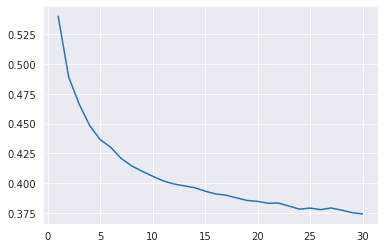


              precision    recall  f1-score   support

           0       0.82      0.79      0.81      3401
           1       0.83      0.85      0.84      3924

    accuracy                           0.82      7325
   macro avg       0.82      0.82      0.82      7325
weighted avg       0.82      0.82      0.82      7325



In [77]:
VOCAB_SIZE = len(w2vmodel.wv.vocab)
padding_idx = w2vmodel.wv.vocab['pad'].index
cnn_model = CnnTextClassifier(vocab_size= VOCAB_SIZE, num_classes= 2, word_vector_model= w2vmodel)

train_the_model(VOCAB_SIZE, padding_idx, cnn_model, word2vec=True)

# Train the network with FastText pretrained vectors

Epoch1
Epoch 1, Loss: 0.5464568995531854


Epoch2
Epoch 2, Loss: 0.488810599316134


Epoch3
Epoch 3, Loss: 0.46547402426141693


Epoch4
Epoch 4, Loss: 0.44690805616533563


Epoch5
Epoch 5, Loss: 0.4351965285747627


Epoch6
Epoch 6, Loss: 0.4254114556307678


Epoch7
Epoch 7, Loss: 0.4187458425859956


Epoch8
Epoch 8, Loss: 0.41461255106431844


Epoch9
Epoch 9, Loss: 0.41070241476844316


Epoch10
Epoch 10, Loss: 0.4058440489350785


Epoch11
Epoch 11, Loss: 0.4011731818343797


Epoch12
Epoch 12, Loss: 0.39756767245268804


Epoch13
Epoch 13, Loss: 0.39547485938409266


Epoch14
Epoch 14, Loss: 0.39338253293926706


Epoch15
Epoch 15, Loss: 0.38933280065601794


Epoch16
Epoch 16, Loss: 0.39001428891761414


Epoch17
Epoch 17, Loss: 0.38825216025156783


Epoch18
Epoch 18, Loss: 0.3860975497604613


Epoch19
Epoch 19, Loss: 0.3832916024663162


Epoch20
Epoch 20, Loss: 0.3809400908356519


Epoch21
Epoch 21, Loss: 0.3833163465275375


Epoch22
Epoch 22, Loss: 0.3794566788930308


Epoch23
Epoch 23, L

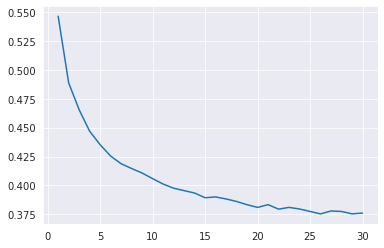


              precision    recall  f1-score   support

           0       0.80      0.83      0.81      3401
           1       0.84      0.82      0.83      3924

    accuracy                           0.82      7325
   macro avg       0.82      0.82      0.82      7325
weighted avg       0.82      0.82      0.82      7325



In [78]:
VOCAB_SIZE = len(fastText_model.wv.vocab)
padding_idx = fastText_model.wv.vocab['pad'].index
cnn_model = CnnTextClassifier(vocab_size= VOCAB_SIZE, num_classes= 2, word_vector_model= fastText_model)

train_the_model(VOCAB_SIZE, padding_idx, cnn_model, word2vec=False)

In [ ]:
string a=5